## FIALA Tire Model

In [1]:
from mg_utils import *

ACADOS_SOURCE_DIR: /Users/marcocortese/repos/acados


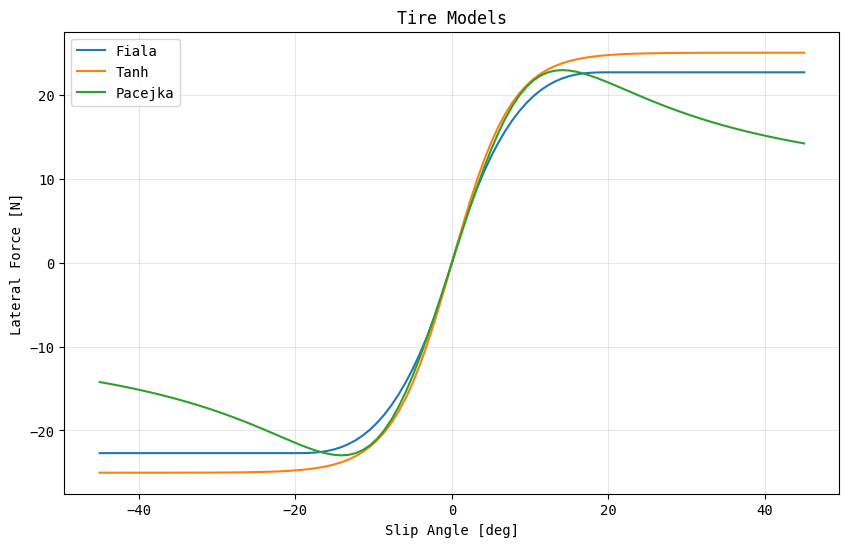

In [ ]:
# tire models
μf, μr = 0.5, 0.47   # [] friction coefficients front and rear
Cyf = 370.36;  # [N/rad] Cornering stiffness front tyre
Cyr = 1134.05; # [N/rad] Cornering stiffness rear tyre

def fiala(α, Fx, Fz, μ, Cy):
    assert Fx**2 <= μ**2 * Fz**2, "Longitudinal force exceeds maximum limit"
    Fy_max = np.sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
    αs = np.atan(3*Fy_max/Cy) # maximum slip angle
    assert αs > 0, "Maximum slip angle must be positive"
    if abs(α) < αs: 
        # return -Cy * tan(α) + Cy**2 * abs(tan(α)) * tan(α) / (3 * Fy_max) \
        #         - Cy**3 * tan(α)**3 / (27 * Fy_max**2)
        return Cy * np.tan(α) - Cy**2 * abs(np.tan(α)) * np.tan(α) / (3 * Fy_max) \
                + Cy**3 * np.tan(α)**3 / (27 * Fy_max**2)
    # else: return -Fy_max * sign(α)
    else: return Fy_max * np.sign(α)

# Test the fiala function
FX = 4 # [N] # longitudinal force
v_α = np.linspace(-π/4, π/4, 100) # slip angle vector
Fy_fiala = np.array([fiala(α, FX, Fz_Front/2, μf, Cyf/2) for α in v_α]) 

# tanh approximation
def fiala_tanh(α, Fx, Fz, μ, Cy):
    assert Fx**2 <= μ**2 * Fz**2, "Longitudinal force exceeds maximum limit"
    Fy_max = np.sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
    αs = np.atan(Fy_max/Cy) # maximum slip angle
    return Fy_max * np.tanh(α / αs) # tanh approximation

def pacejka(α, Fx, Fz, μ, Cy):
    assert Fx**2 <= μ**2 * Fz**2, "Longitudinal force exceeds maximum limit"
    Fy_max = np.sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
    # αs = np.atan(Fy_max/Cy) # maximum slip angle
    pB, pC, pD, pE = 4,1.8,Fy_max/2,-1 # Pacejka parameters
    return pD * np.sin(pC * np.arctan(pB * α - pE * (pB*α - np.arctan(pB*α))))

# Test the fiala_tanh function
Fy_fiala_tanh = np.array([fiala_tanh(α, FX, Fz_Front/2, μf-0.05, Cyf/2) for α in v_α])
# Test the pacejka function
Fy_pacejka = np.array([pacejka(α, FX, Fz_Front, μf, Cyf) for α in v_α])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.rad2deg(v_α), Fy_fiala, label='Fiala')
plt.plot(np.rad2deg(v_α), Fy_fiala_tanh, label='Tanh')
plt.plot(np.rad2deg(v_α), Fy_pacejka, label='Pacejka')
plt.title('Tire Models')
plt.xlabel('Slip Angle [deg]')
plt.ylabel('Lateral Force [N]')
plt.legend()
plt.show()

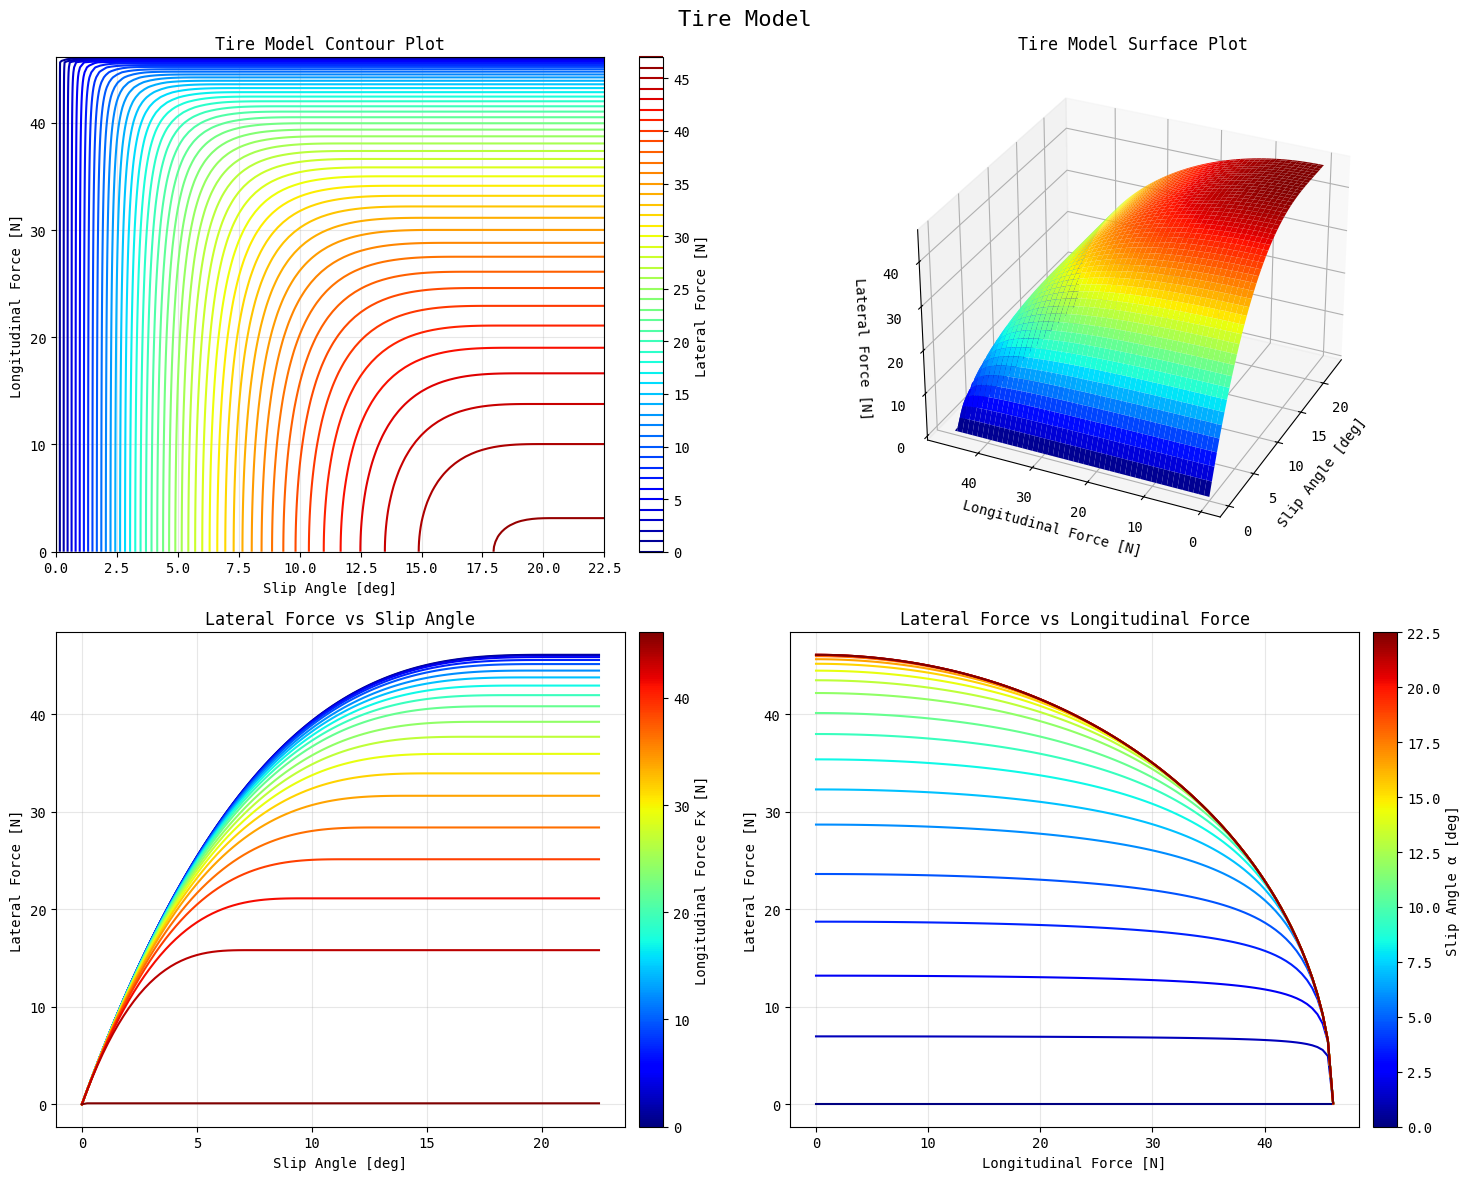

In [3]:
# show 3d plot of tire model, alpha on x-axis, Fx on y-axis, Fy on z-axis

tire = fiala
# tire = fiala_tanh

# let's to a contour plot first
α_min, α_max, α_n = np.deg2rad(0), π/8, 100 # [rad]
Fx_min, Fx_max, Fx_n = 0, μf*Fz_Front-0.0001, 100 # [N]
α_ = np.linspace(α_min, α_max, α_n) # slip angle vector
Fx_ = np.linspace(Fx_min, Fx_max, Fx_n) # longitudinal force vector

α_grid, Fx_grid = np.meshgrid(α_, Fx_) # create a grid of slip angles and longitudinal forces
grid = np.stack((α_grid, Fx_grid), axis=-1) # stack the grids to create a 2D grid of (α, Fx) pairs



# calculate the lateral force for each (α, Fx) pair
Fy_grid = np.array([[abs(tire(α, Fx, Fz_Front, μf, Cyf)) for α, Fx in grid.reshape(-1, 2)]]).reshape(α_n, Fx_n) 

# plot the contour plot
fig = plt.figure(figsize=(15, 12))
plt.subplot(2,2,1)
# plt.contourf(np.rad2deg(α_grid), Fx_grid, Fy_grid, levels=50, cmap=CM)
plt.contour(np.rad2deg(α_grid), Fx_grid, Fy_grid, levels=50, cmap=CM)
plt.colorbar(label='Lateral Force [N]')
plt.title('Tire Model Contour Plot')
plt.xlabel('Slip Angle [deg]')
plt.ylabel('Longitudinal Force [N]')

# 3D surface plot of the tire model
# fig = plt.figure(figsize=(10, 10))
plt.subplot(2,2,2, projection='3d')
# ax = fig.add_subplot(111, projection='3d')
ax = plt.gca()
ax.plot_surface(np.rad2deg(α_grid), Fx_grid, Fy_grid, cmap=CM, edgecolor='none')
ax.set_title('Tire Model Surface Plot')
ax.set_xlabel('Slip Angle [deg]')
ax.set_ylabel('Longitudinal Force [N]')
ax.set_zlabel('Lateral Force [N]')
ax.view_init(elev=None, azim=205)
# plt.show()

# 2 2D subplots, first has alpha on x-axis, Fy on y-axis, Fx are different lines, second has Fx on x-axis, Fy on y-axis, alpha are different lines

# Get colormap and colors for lines
from matplotlib import colormaps
n_lines = 20 # number of lines to plot
colors = colormaps[CM](np.linspace(0, 1, n_lines))

# First subplot: alpha on x-axis, Fy on y-axis, Fx are different lines
plt.subplot(2, 2, 3)
indices = np.linspace(0, Fx_n - 1, n_lines, dtype=int)
for idx, i in enumerate(indices):
    plt.plot(np.rad2deg(α_), Fy_grid[i, :], label=f'Fx = {Fx_[i]:.1f} N', color=colors[idx])
plt.title('Lateral Force vs Slip Angle')
plt.xlabel('Slip Angle [deg]')
plt.ylabel('Lateral Force [N]')
# plt.legend()
sm = plt.cm.ScalarMappable(cmap=CM, norm=plt.Normalize(vmin=Fx_min, vmax=Fx_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar.set_label('Longitudinal Force Fx [N]')

# Second subplot: Fx on x-axis, Fy on y-axis, alpha are different lines
plt.subplot(2, 2, 4)
indices = np.linspace(0, α_n - 1, n_lines, dtype=int)
for idx, i in enumerate(indices):
    plt.plot(Fx_, Fy_grid[:, i], label=f'α = {np.rad2deg(α_[i]):.1f} deg', color=colors[idx])
plt.title('Lateral Force vs Longitudinal Force')
plt.xlabel('Longitudinal Force [N]')
plt.ylabel('Lateral Force [N]')
# plt.legend()
sm = plt.cm.ScalarMappable(cmap=CM, norm=plt.Normalize(vmin=np.rad2deg(α_min), vmax=np.rad2deg(α_max)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar.set_label('Slip Angle α [deg]')

plt.suptitle('Tire Model', fontsize=16)
plt.tight_layout()
plt.show()